# Machines Learning Strategies

### Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import shap
from MachineLearningStrategy.data_loader import load_historical_data
from MachineLearningStrategy.feature_engineering import create_features
from MachineLearningStrategy.model_training import train_model
from MachineLearningStrategy.portfolio_optimizer import optimize_portfolio
from MachineLearningStrategy.backtester import walk_forward_validation
from MachineLearningStrategy.risk_manager import RiskManager
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Load hyperparameters
with open("MachineLearningStrategy\params.yaml", "r") as f:
    params = yaml.safe_load(f)

# Set random seed for reproducibility
np.random.seed(42)

c:\Users\10037\.conda\envs\pyfi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[*********************100%***********************]  3 of 3 completed


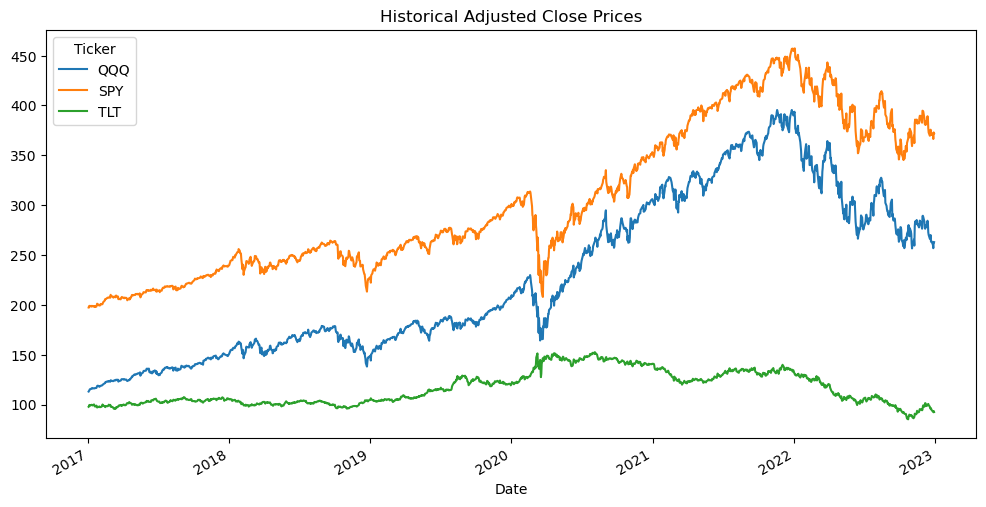

In [2]:
#Load & Preprocess Data
# Fetch historical data for S&P 500, Nasdaq, and Treasury ETFs
tickers = ["SPY", "QQQ", "TLT"]
start_date = "2017-01-01"
end_date = "2022-12-31"

raw_data = load_historical_data(tickers, start_date, end_date)
returns = raw_data.pct_change().dropna()

# Plot raw price data
raw_data.plot(figsize=(12, 6), title="Historical Adjusted Close Prices")
plt.show()

In [3]:
#Feature Engineering
# Generate technical features (momentum, volatility, RSI)
features = create_features(raw_data, window=30)

# Add target variable: 5-day forward returns
features['target'] = raw_data.shift(-5).pct_change(5).shift(5).iloc[:, 0]  # Predict SPY returns

# Drop missing values
features = features.dropna()

# Preview features
features.head()

C:\Users\10037\AppData\Local\Temp\ipykernel_20296\3554918347.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['target'] = raw_data.shift(-5).pct_change(5).shift(5).iloc[:, 0]  # Predict SPY returns


,QQQ_momentum,QQQ_volatility,QQQ_RSI,SPY_momentum,SPY_volatility,SPY_RSI,TLT_momentum,TLT_volatility,TLT_RSI,target
Date,,,,,,,,,,
2017-02-15,117.462602,0.003622,85.662106,199.758910,0.003740,71.959857,98.449656,0.007633,49.064997,0.022055
2017-02-16,117.769799,0.003620,84.686297,200.041535,0.003660,69.473397,98.438146,0.007667,49.492482,0.018037
2017-02-17,118.055257,0.003588,84.544256,200.279197,0.003642,70.601995,98.431846,0.007171,46.765315,0.019077
2017-02-21,118.336934,0.003416,84.025788,200.532920,0.003719,71.401929,98.393746,0.006981,48.817134,0.018345
2017-02-22,118.605378,0.003427,83.566350,200.803867,0.003640,73.225686,98.380399,0.006820,46.843933,0.015327


In [4]:
print("Columns in 'features':", features.columns.tolist())

Columns in 'features': ['QQQ_momentum', 'QQQ_volatility', 'QQQ_RSI', 'SPY_momentum', 'SPY_volatility', 'SPY_RSI', 'TLT_momentum', 'TLT_volatility', 'TLT_RSI', 'target']


In [5]:
# Define X and y for single-target modeling
X = features.drop(['target'], axis=1)  # Drop the single 'target' column
y = features['target']                 # Use the existing target

In [6]:
# Add individual target columns
features['target_SPY'] = raw_data['SPY'].shift(-5).pct_change(5).shift(5)
features['target_QQQ'] = raw_data['QQQ'].shift(-5).pct_change(5).shift(5)
features['target_TLT'] = raw_data['TLT'].shift(-5).pct_change(5).shift(5)

# Drop the old single 'target' column
features = features.drop('target', axis=1)

# Define X and y for multi-target modeling
X = features.drop(['target_SPY', 'target_QQQ', 'target_TLT'], axis=1)
y = features[['target_SPY', 'target_QQQ', 'target_TLT']]

C:\Users\10037\AppData\Local\Temp\ipykernel_20296\436424510.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['target_SPY'] = raw_data['SPY'].shift(-5).pct_change(5).shift(5)
C:\Users\10037\AppData\Local\Temp\ipykernel_20296\436424510.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['target_QQQ'] = raw_data['QQQ'].shift(-5).pct_change(5).shift(5)
C:\Users\10037\AppData\Local\Temp\ipykernel_20296\436424510.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values pr

In [7]:
print("Columns in 'features':", features.columns.tolist())
# Expected Output: ['QQQ_momentum', ..., 'target_SPY', 'target_QQQ', 'target_TLT']

Columns in 'features': ['QQQ_momentum', 'QQQ_volatility', 'QQQ_RSI', 'SPY_momentum', 'SPY_volatility', 'SPY_RSI', 'TLT_momentum', 'TLT_volatility', 'TLT_RSI', 'target_SPY', 'target_QQQ', 'target_TLT']


In [8]:
# Define features (X) and target (y) **ONCE**
X = features.drop(['target_SPY', 'target_QQQ', 'target_TLT'], axis=1)
y = features[['target_SPY', 'target_QQQ', 'target_TLT']]

# Check if X and y are defined
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1480, 9)
Shape of y: (1480, 3)


Missing values in features: 0
Missing values in target: target_SPY    0
target_QQQ    0
target_TLT    0
dtype: int64


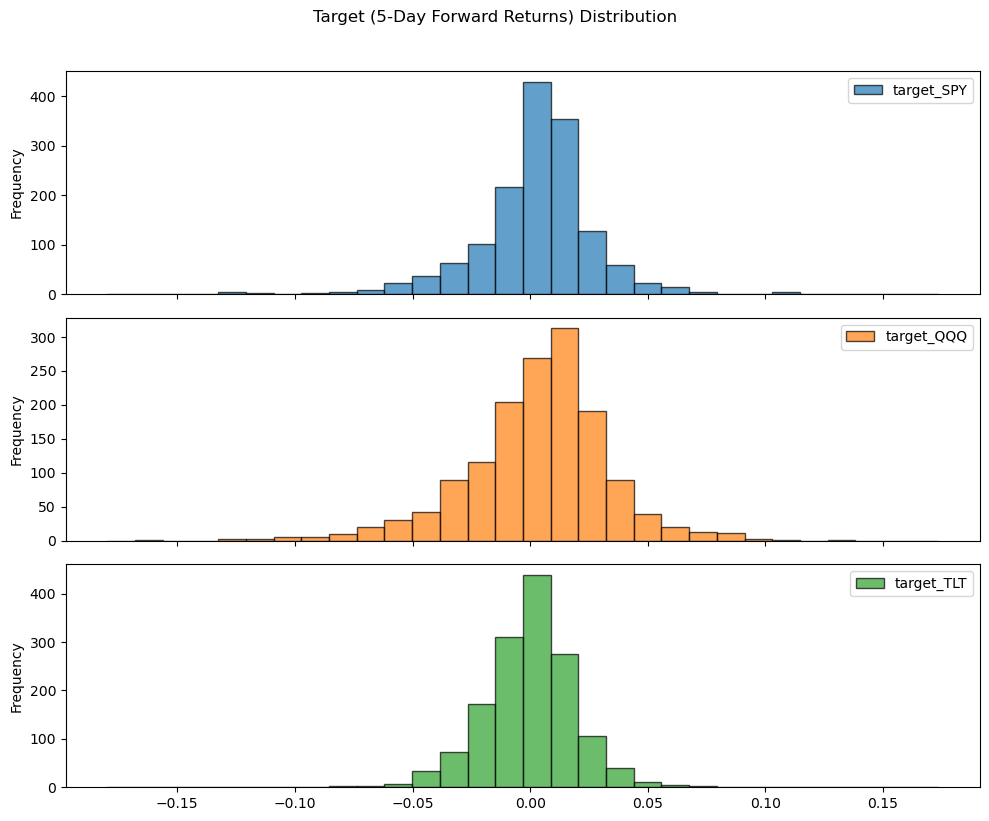

In [9]:
# Check for NaN values
print("Missing values in features:", X.isna().sum().sum())  
print("Missing values in target:", y.isna().sum())

# Check target variable distribution
y.plot(kind='hist', 
       subplots=True, 
       layout=(3, 1),
       figsize=(10, 8), 
       bins=30,
       edgecolor='black',
       alpha=0.7)

plt.suptitle('Target (5-Day Forward Returns) Distribution', y=1.02)
plt.tight_layout()
plt.show()

### Train Machine Learning Model

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import shap
from sklearn.multioutput import MultiOutputRegressor

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
shap_values_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Wrap GradientBoostingRegressor for multi-output
    model = MultiOutputRegressor(
        GradientBoostingRegressor(**params['model'])
    )
    model.fit(X_train, y_train)
    
    # SHAP analysis for each target
    for i, estimator in enumerate(model.estimators_):
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X_test)
        shap_values_list.append(shap_values)

In [11]:
# 1. Recreate the 'target' column if missing
features['target'] = raw_data['SPY'].shift(-5).pct_change(5).shift(5)

# 2. Split data
X = features.drop('target', axis=1)
y = features['target']

# 3. Verify
print("Columns in X:", X.columns.tolist())
print("Target variable (y):", y.name)

# 4. Train model
model = train_model(X, y, model_type='GradientBoosting')

C:\Users\10037\AppData\Local\Temp\ipykernel_20296\375223918.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features['target'] = raw_data['SPY'].shift(-5).pct_change(5).shift(5)


Columns in X: ['QQQ_momentum', 'QQQ_volatility', 'QQQ_RSI', 'SPY_momentum', 'SPY_volatility', 'SPY_RSI', 'TLT_momentum', 'TLT_volatility', 'TLT_RSI', 'target_SPY', 'target_QQQ', 'target_TLT']
Target variable (y): target
[INFO] Model trained | MSE: 0.0000


### Portfolio Optimization

In [12]:
from sklearn.multioutput import MultiOutputRegressor

# Features (X) and multi-target (y)
X = features.drop(['target_SPY', 'target_QQQ', 'target_TLT'], axis=1)
y = features[['target_SPY', 'target_QQQ', 'target_TLT']]

# Train a model for each asset
multi_model = MultiOutputRegressor(GradientBoostingRegressor(**params['model']))
multi_model.fit(X, y)

# Get expected returns for all assets
# After training multi_model:
expected_returns = multi_model.predict(X)  # Shape: (n_samples, 3)
mean_expected_returns = expected_returns.mean(axis=0)  # Shape: (3,)

In [13]:
# Calculate covariance matrix (3x3)
cov_matrix = returns[['SPY', 'QQQ', 'TLT']].cov() * 252

# Optimize weights
weights = optimize_portfolio(
    expected_returns.mean(axis=0),  # Shape: (3,)
    cov_matrix.values               # Shape: (3, 3)
)

print("Shape of mean_expected_returns:", mean_expected_returns.shape)  # Should be (3,)
print("Shape of covariance matrix:", cov_matrix.values.shape)          # Should be (3, 3)

Optimization error: Optimization failed: Infeasible or unbounded problem.
Shape of mean_expected_returns: (3,)
Shape of covariance matrix: (3, 3)


In [14]:
#Ensure No NaN/Inf Values
print("NaN in covariance matrix:", np.isnan(cov_matrix.values).any())
print("Inf in covariance matrix:", np.isinf(cov_matrix.values).any())

NaN in covariance matrix: False
Inf in covariance matrix: False


In [15]:
print("Mean expected returns:", mean_expected_returns)
print("Target return:", params['backtesting']['target_return'])

# Ensure target return <= max(expected_returns)
if params['backtesting']['target_return'] > max(mean_expected_returns):
    print("Error: Target return is higher than the maximum expected return.")
    params['backtesting']['target_return'] = max(mean_expected_returns) * 0.9  # Adjust to 90% of max

Mean expected returns: [ 2.37600642e-03  3.09238104e-03 -7.61305118e-06]
Target return: 0.15
Error: Target return is higher than the maximum expected return.


In [16]:
eigenvalues = np.linalg.eigvals(cov_matrix.values)
print("Covariance matrix eigenvalues:", eigenvalues)

if any(e < 0 for e in eigenvalues):
    print("Covariance matrix is not PSD. Applying regularization...")
    cov_matrix_psd = cov_matrix.values + 1e-6 * np.eye(cov_matrix.shape[0])
else:
    cov_matrix_psd = cov_matrix.values

Covariance matrix eigenvalues: [0.09646387 0.00309611 0.02218296]


In [17]:
# Use the regularized covariance matrix
weights = optimize_portfolio(
    mean_expected_returns, 
    cov_matrix_psd,
    target_return=params['backtesting']['target_return']
)

if weights is not None:
    print("Optimal Portfolio Weights:")
    for ticker, weight in zip(['SPY', 'QQQ', 'TLT'], weights):
        print(f"{ticker}: {weight:.2%}")
else:
    print("Failed to compute weights.")

Optimal Portfolio Weights:
SPY: 0.00%
QQQ: 90.02%
TLT: 9.98%


### Backtest Strategy

In [18]:

# Run Walk-Forward Validation
sharpe, max_drawdown = walk_forward_validation(
    features, 
    model, 
    train_window=params['backtesting']['train_window'],
    test_window=params['backtesting']['test_window']
)

print(f"\nStrategy Performance:")
print(f"- Sharpe Ratio: {sharpe:.2f}")
print(f"- Max Drawdown: {max_drawdown:.2%}")


Strategy Performance:
- Sharpe Ratio: 3.13
- Max Drawdown: -1055.49%


### Risk Management

In [21]:
# 1. Define spy_price
spy_price = raw_data['SPY'].iloc[-1]  # Add this line

# 2. Compute volatility series
volatility_series = returns['SPY'].rolling(30).std().dropna()

# 3. Initialize RiskManager instance
risk_manager = RiskManager(
    max_capital_risk=params['risk']['max_capital_risk'],
    volatility_window=params['risk']['volatility_window']
)

# 4. Calculate position size using the instance
position_size = risk_manager.calculate_position_size(  # Call on the instance
    spy_price, 
    volatility_series
)

print(f"Position Size for SPY: {position_size:.0f} shares")

Position Size for SPY: 1 shares


### Visualize Results

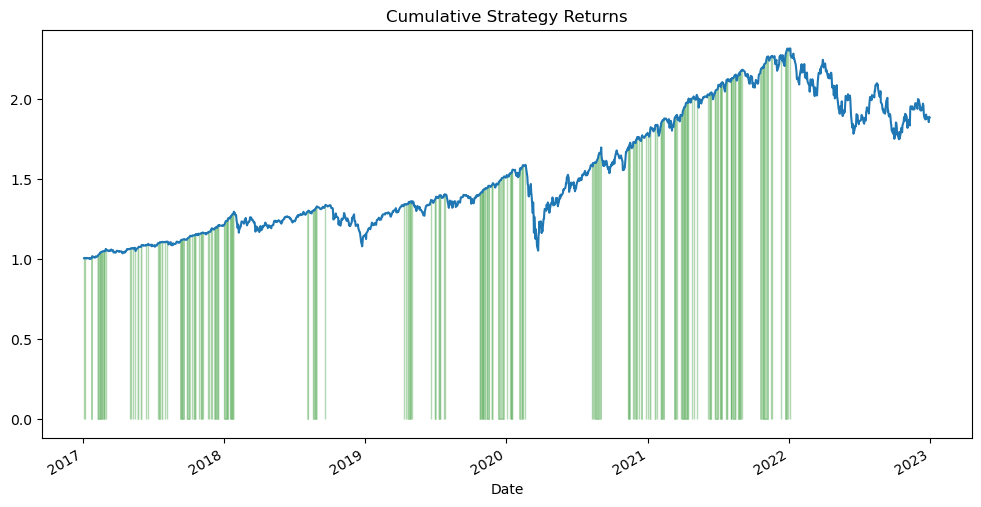

In [22]:
# Plot cumulative returns
cumulative_returns = (1 + returns['SPY']).cumprod()
cumulative_returns.plot(figsize=(12, 6), title="Cumulative Strategy Returns")
plt.fill_between(
    cumulative_returns.index, 
    cumulative_returns, 
    where=(cumulative_returns >= cumulative_returns.cummax()),
    color="green", 
    alpha=0.3
)
plt.show()